###Import necessary libraries

In [ ]:
import os
import random
import cv2
#import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import deque

from moviepy.editor import *

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical,plot_model
from tensorflow.keras.callbacks import EarlyStopping


###SET random state or seed constant

In [ ]:
seed_constant = 10
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

###**Step 1 :** Download and visualize the data with its labels
**we will use ucf_sports_actions dataset. it contains...**










In [ ]:
#download and extract the data
#download Ucf sports dataset
!wget --no-check-certificate https://www.crcv.ucf.edu/data/ucf_sports_actions.zip



--2023-11-06 12:12:40--  https://www.crcv.ucf.edu/data/ucf_sports_actions.zip
Resolving www.crcv.ucf.edu (www.crcv.ucf.edu)... 132.170.214.127
Connecting to www.crcv.ucf.edu (www.crcv.ucf.edu)|132.170.214.127|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 1777599139 (1.7G) [application/zip]
Saving to: ‘ucf_sports_actions.zip’

ucf_sports_actions. 100%[===================>]   1.66G  50.9MB/s    in 33s     

2023-11-06 12:13:14 (51.0 MB/s) - ‘ucf_sports_actions.zip’ saved [1777599139/1777599139]



In [ ]:
#extract it
!unzip  ucf_sports_actions.zip

Streaming output truncated to the last 5000 lines.
  inflating: ucf_sports_actions/ucf action/Walk-Front/005/RF1-11529_70095.jpg  
  inflating: ucf_sports_actions/ucf action/Walk-Front/005/RF1-11529_70096.jpg  
  inflating: ucf_sports_actions/ucf action/Walk-Front/005/RF1-11529_70097.jpg  
  inflating: ucf_sports_actions/ucf action/Walk-Front/005/RF1-11529_70098.jpg  
  inflating: ucf_sports_actions/ucf action/Walk-Front/005/RF1-11529_70099.jpg  
  inflating: ucf_sports_actions/ucf action/Walk-Front/005/RF1-11529_70100.jpg  
  inflating: ucf_sports_actions/ucf action/Walk-Front/005/Thumbs.db  
   creating: ucf_sports_actions/ucf action/Walk-Front/006/
   creating: ucf_sports_actions/ucf action/Walk-Front/006/gt/
 extracting: ucf_sports_actions/ucf action/Walk-Front/006/gt/RF1-13902_70016.tif.txt  
 extracting: ucf_sports_actions/ucf action/Walk-Front/006/gt/RF1-13902_70017.tif.txt  
 extracting: ucf_sports_actions/ucf action/Walk-Front/006/gt/RF1-13902_70018.tif.txt  
 extracting: ucf_

###visualization

IndexError: ignored

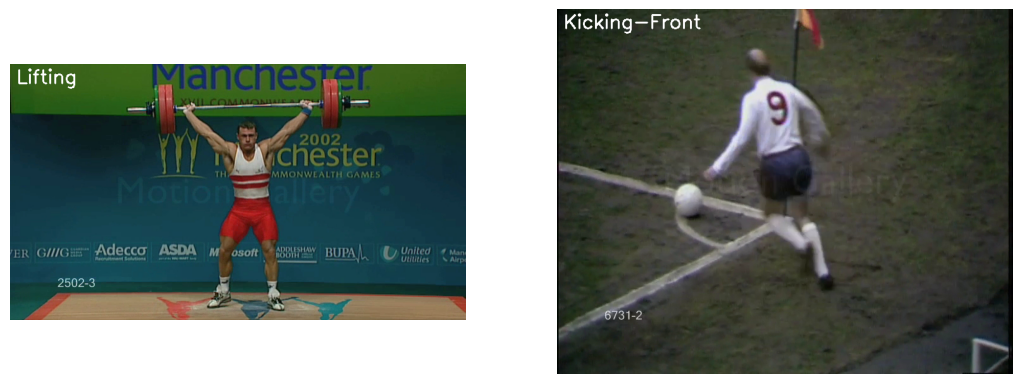

In [ ]:
#create a figure
plt.figure(figsize=(20,20))
dir = 'ucf_sports_actions/ucf_action'
#all classes in data
all_classes = os.listdir('ucf_sports_actions/ucf_action')


# select random 5  categories
random_categories = random.sample(range(len(all_classes)),5)

#iterating through all values
for counter,random_index in enumerate(random_categories,1):

  #retrive a class name
  selected_class = all_classes[random_index]
  sub_class = os.listdir(f"{dir}/{selected_class}")
  selected_sub_class = sub_class[random_index]
  #list of all video files present in the class
  video_files_list = os.listdir(f'{dir}/{selected_class}/{selected_sub_class}')

  #randomly select a video file
  selected_video = random.choice((video_files_list))

  # initailize a videocapture object to read from the video file
  video_reader = cv2.VideoCapture(f'{dir}/{selected_class}/{selected_sub_class}/{selected_video}')

  # read the first name of the video file
  _,bgr_frame =  video_reader.read()

  #release the videocapture object
  video_reader.release()

  #covert the frame bgr to rgb format
  rgb_frame = cv2.cvtColor(bgr_frame,cv2.COLOR_BGR2RGB)


  #write the class name on the video frame
  cv2.putText(rgb_frame,selected_class,(10,30),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)

  #display the frame
  plt.subplot(2,3,counter)
  plt.imshow(rgb_frame)
  plt.axis('off')

###**STEP 2: DATA PREPROCESSING**

In [ ]:
#specify the height and width of frame
image_height,image_width =224,224

#Specify the number of frames of a vedio that will be fed to model as one sequence
Sequence_length = 20

#specify the directory containing the ucf_sports_actions dataset
dataset_dir = dir

#specify the classes
class_list = all_classes

### **CREATE A FUNCTION TO RESIZE AND EXTRACT FRAMES**

In [ ]:
def frame_extraction(video_path):
  frames_list =[]
  #read the video files
  video_reader = cv2.VideoCapture(video_path)

  #total number of frames in the vedio
  video_frame_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

  # define the interval after which frames will be added to list
  skip_frames_window = max(int(video_frame_count/Sequence_length),1)

  #iterate through the video frames
  for frame_counter in range(Sequence_length):

    #set the current frame position
    video_reader.set(cv2.CAP_PROP_POS_FRAMES,frame_counter*skip_frames_window)

    #reading the frame from the video
    success ,frame = video_reader.read()

    # check if the video frame is not successfully read then break the rule
    if not success:
      print('error')
      break

    #resize the frame to fix height width
    resized_frame = cv2.resize(frame,(image_height,image_width))

    #normalize the resized frame by dividing it with 255 so that each pixel lies between 0 and 1
    normalized_frame = resized_frame/255

    #append the normalized frame into the frame list
    frames_list.append(normalized_frame)

  #release the object
  video_reader.release()

  #return the frame list
  return frames_list


### **create a function for dataset creation**

In [ ]:
def create_dataset():

  features = []
  labels = []
  video_file_paths = []

  #iterating through all the classes
  for class_index,class_name in enumerate(class_list):
    #iterating through all the subclasses
    for i in range (5):
      selected_class = all_classes[class_index]
      sub_class = os.listdir(f"{dir}/{selected_class}")
      selected_sub_class = sub_class[i]
      print(f"extracting data of the class:{class_name}/{selected_sub_class}")
      #get the list of vedio files present in the class
      files_list = os.listdir(os.path.join(dataset_dir,class_name,selected_sub_class))
      #iterate through all the files present in the file list
      for file_name in files_list:
        if '.avi' in file_name:
          #get the complete video path
          video_file_path = os.path.join(dataset_dir,class_name,selected_sub_class,file_name)
          print("frame execution started")
          #extract the frames of the video files
          frames = frame_extraction(video_file_path)
          print('len of frame is',len(frames))
          if len(frames) == Sequence_length:
            #append  the data to their respective list
            features.append(frames)
            labels.append(class_index)
            video_file_paths.append(video_file_path)
        else:
          pass
    # converting list to numpy arrays
  features = np.asarray(features)
  labels = np.asarray(labels)
  return features,labels,video_file_paths

In [ ]:
#create the dataset
features,labels,video_file_paths = create_dataset()

extracting data of the class:Lifting/003
frame execution started
len of frame is 20
extracting data of the class:Lifting/002
frame execution started
len of frame is 20
extracting data of the class:Lifting/001
frame execution started
len of frame is 20
extracting data of the class:Lifting/004
frame execution started
len of frame is 20
extracting data of the class:Lifting/005
frame execution started
len of frame is 20
extracting data of the class:Swing-SideAngle/003
frame execution started
error
len of frame is 3
extracting data of the class:Swing-SideAngle/002
frame execution started
len of frame is 20
extracting data of the class:Swing-SideAngle/001
frame execution started
len of frame is 20
extracting data of the class:Swing-SideAngle/004
frame execution started
len of frame is 20
extracting data of the class:Swing-SideAngle/009
frame execution started
len of frame is 20
extracting data of the class:Walk-Front/003
frame execution started
len of frame is 20
extracting data of the class

###one hot encoding

In [ ]:
encoded_labels = to_categorical(labels)

###split the data into training and testing set

In [ ]:
x_train , x_test , y_train ,y_test = train_test_split(features,encoded_labels,test_size=0.25,shuffle = True,random_state = seed_constant)

In [ ]:
x_train[0].shape,y_test.shape

((20, 224, 224, 3), (15, 13))

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import TimeDistributed, LSTM, Dense

# Load the ResNet-v2 model without the classification layers
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers
for layer in base_model.layers:
    layer.trainable = False

# Define the model architecture
model = tf.keras.Sequential([
    TimeDistributed(base_model, input_shape=(20, 224, 224, 3)),  # 20 frames in the video
    TimeDistributed(tf.keras.layers.Flatten()),  # Flatten the output
    LSTM(256),  # LSTM layer
    Dense(64, activation='relu'),
    Dense(28, activation='relu'),
    Dense(13, activation='softmax')  # Example output layer, change as needed
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Assuming you have video data loaded and preprocessed
# video_data is of shape (batch_size, frames, height, width, channels)


# Train the model
history=model.fit(x_train, y_train, epochs=30, batch_size=32,validation_data=(x_test,y_test))  # Adjust epochs and batch_size as needed


Epoch 1/30
2/2 [==============================] - 53s 20s/step - loss: 2.6469 - accuracy: 0.0698 - val_loss: 2.3721 - val_accuracy: 0.2667
Epoch 2/30
2/2 [==============================] - 3s 2s/step - loss: 2.1817 - accuracy: 0.3953 - val_loss: 2.2697 - val_accuracy: 0.4000
Epoch 3/30
2/2 [==============================] - 4s 2s/step - loss: 1.8021 - accuracy: 0.6977 - val_loss: 2.2216 - val_accuracy: 0.3333
Epoch 4/30
2/2 [==============================] - 4s 2s/step - loss: 1.6621 - accuracy: 0.7674 - val_loss: 2.1644 - val_accuracy: 0.2000
Epoch 5/30
2/2 [==============================] - 4s 2s/step - loss: 1.5269 - accuracy: 0.7674 - val_loss: 2.1835 - val_accuracy: 0.0667
Epoch 6/30
2/2 [==============================] - 3s 2s/step - loss: 1.4294 - accuracy: 0.7442 - val_loss: 2.1186 - val_accuracy: 0.1333
Epoch 7/30
2/2 [==============================] - 4s 2s/step - loss: 1.3207 - accuracy: 0.7442 - val_loss: 2.0855 - val_accuracy: 0.2667
Epoch 8/30
2/2 [=======================

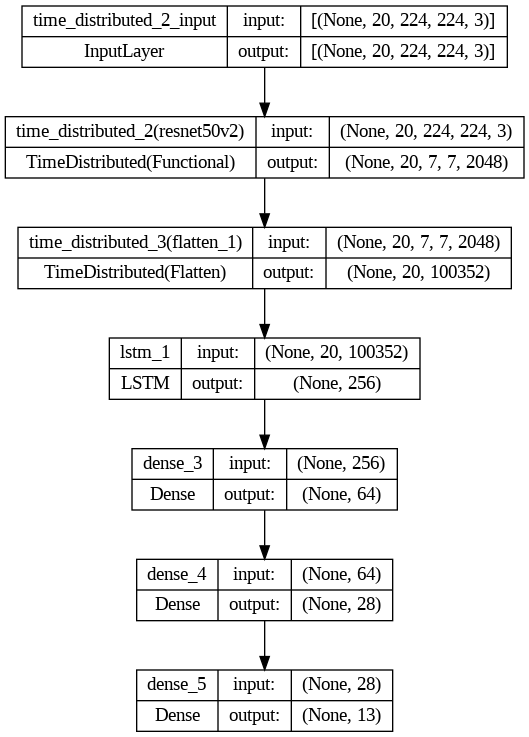

In [ ]:
plot_model(model,show_shapes=True)

<Axes: >

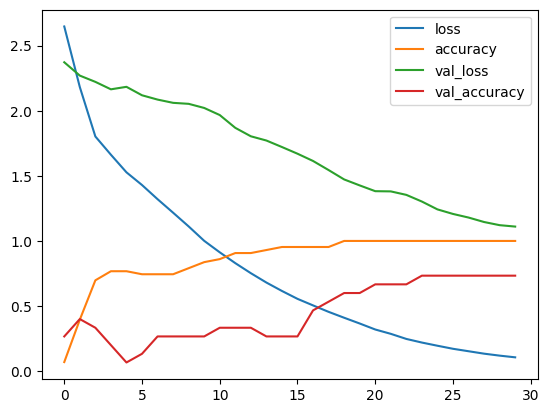

In [ ]:
import pandas as pd
pd.DataFrame(history.history).plot()

In [ ]:
def create_LRCN():

  model =Sequential()

  ########################################################
  #model architecture

  model.add(TimeDistributed(Conv2D(16,(3,3),padding='same',activation = 'relu'),
                            input_shape = (Sequence_length,image_height,image_width,3)))
  model.add(TimeDistributed(MaxPooling2D((4,4))))
  model.add(TimeDistributed(Dropout(0.22)))

  model.add(TimeDistributed(Conv2D(32,(3,3),padding='same',activation = 'relu')))
  model.add(TimeDistributed(MaxPooling2D((4,4))))
  model.add(TimeDistributed(Dropout(0.22)))

  model.add(TimeDistributed(Conv2D(64,(3,3),padding='same',activation = 'relu')))
  model.add(TimeDistributed(MaxPooling2D((2,2))))
  model.add(TimeDistributed(Dropout(0.22)))

  model.add(TimeDistributed(Conv2D(64,(3,3),padding='same',activation = 'relu')))
  model.add(TimeDistributed(MaxPooling2D((2,2))))

  model.add(TimeDistributed(Flatten()))

  model.add(LSTM(256))

  model.add(Dense(len(class_list),activation = 'softmax'))

  ###############################################################################

  model.summary()

  return model

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_16 (TimeD  (None, 20, 224, 224, 16   448       
 istributed)                 )                                   
                                                                 
 time_distributed_17 (TimeD  (None, 20, 56, 56, 16)    0         
 istributed)                                                     
                                                                 
 time_distributed_18 (TimeD  (None, 20, 56, 56, 16)    0         
 istributed)                                                     
                                                                 
 time_distributed_19 (TimeD  (None, 20, 56, 56, 32)    4640      
 istributed)                                                     
                                                                 
 time_distributed_20 (TimeD  (None, 20, 14, 14, 32)   

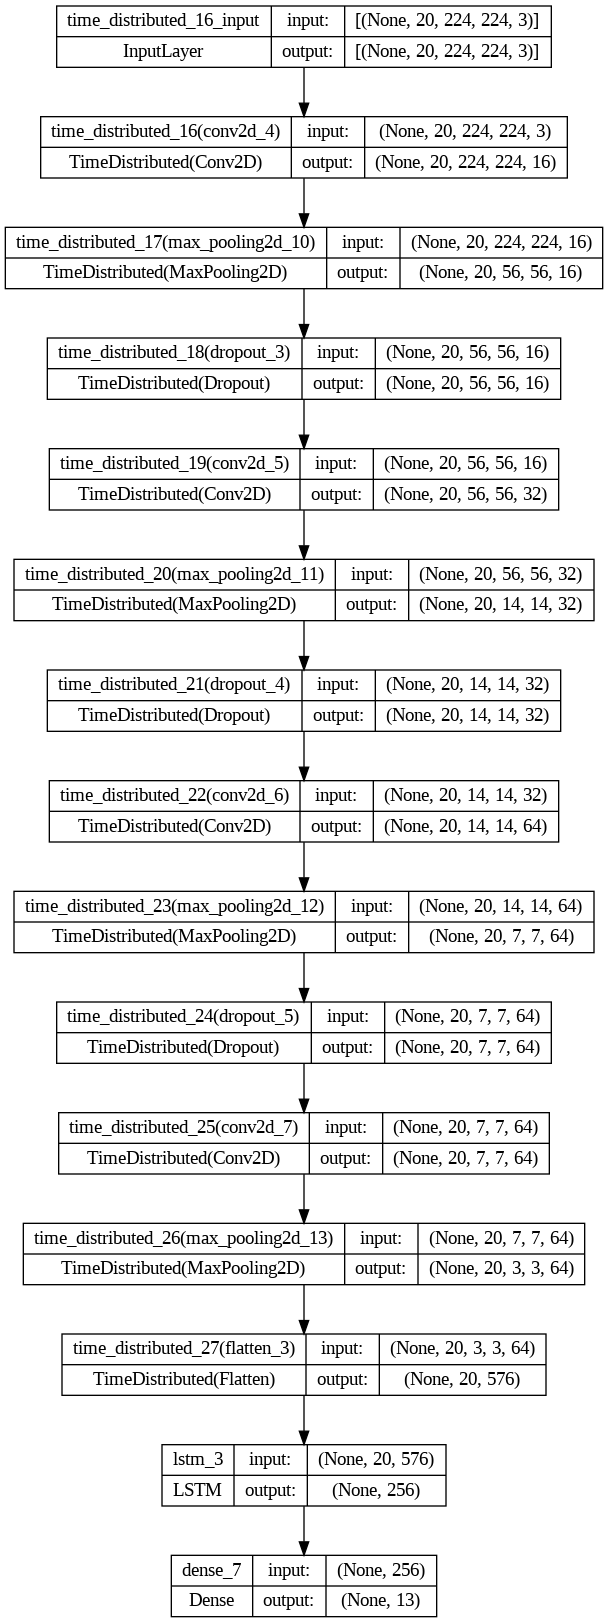

In [ ]:
# create and plot model

LRCN_model = create_LRCN()

plot_model(LRCN_model,show_shapes=True,show_layer_names = True ,to_file = 'LRCN.png')

In [ ]:
#create early stoppage point
early_stopping_point = EarlyStopping(monitor ='val_loss',patience=10,mode = 'min',restore_best_weights=True)

#compile the model
LRCN_model.compile(loss = 'categorical_crossentropy',optimizer = 'Adam',metrics = ['accuracy'])

#start training

model_history = LRCN_model.fit(x_train,y_train,epochs =30 ,batch_size = 32,
                                   shuffle = True ,validation_split = 0.2,
                                   callbacks = [early_stopping_point])

Epoch 1/30
2/2 [==============================] - 12s 2s/step - loss: 2.6035 - accuracy: 0.0000e+00 - val_loss: 2.5836 - val_accuracy: 0.1111
Epoch 2/30
2/2 [==============================] - 1s 394ms/step - loss: 2.6620 - accuracy: 0.1471 - val_loss: 2.5772 - val_accuracy: 0.1111
Epoch 3/30
2/2 [==============================] - 1s 344ms/step - loss: 2.5260 - accuracy: 0.1471 - val_loss: 2.5927 - val_accuracy: 0.1111
Epoch 4/30
2/2 [==============================] - 1s 203ms/step - loss: 2.4642 - accuracy: 0.1471 - val_loss: 2.6224 - val_accuracy: 0.1111
Epoch 5/30
2/2 [==============================] - 1s 211ms/step - loss: 2.4857 - accuracy: 0.1176 - val_loss: 2.6764 - val_accuracy: 0.0000e+00
Epoch 6/30
2/2 [==============================] - 1s 380ms/step - loss: 2.5862 - accuracy: 0.1176 - val_loss: 2.7017 - val_accuracy: 0.1111
Epoch 7/30
2/2 [==============================] - 1s 213ms/step - loss: 2.6601 - accuracy: 0.1471 - val_loss: 2.6742 - val_accuracy: 0.1111
Epoch 8/30
2/2

In [ ]:
LRCN_model.evaluate(x_test,y_test)

1/1 [==============================] - 1s 1s/step - loss: 2.6339 - accuracy: 0.0000e+00


[2.63391375541687, 0.0]

<Axes: >

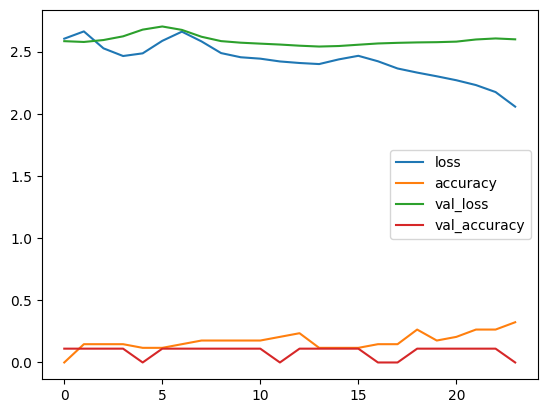

In [ ]:
import pandas as pd
pd.DataFrame(model_history.history).plot()